In [3]:
# load up the data in Phi4 into a dataframe

import pandas as pd
import numpy as np
import os
import itertools
import jax.numpy as jnp
from sampler_evaluation.models.phi4 import phi4


samplers = {"adjusted_microcanonical", "nuts", "unadjusted_microcanonical"}

reduced_lam = jnp.linspace(-2.5, 7.5, 8) #lambda range around the critical point (m^2 = -4 is fixed)



def unreduce_lam(reduced_lam, side):
    """see Fig 3 in https://arxiv.org/pdf/2207.00283.pdf"""
    return 4.25 * (reduced_lam * np.power(side, -1.0) + 1.0)


models={
                phi4(L=L, lam=lam).name for L in [8,16] for lam in unreduce_lam(reduced_lam=reduced_lam,side=L) 
            }

import os
print(os.listdir())

df = pd.concat([pd.read_csv(os.path.join("results", f'{sampler}_{model}.csv')) for sampler, model in itertools.product(samplers, models)], ignore_index=True)

df = df[df['max'] == True]
df = df[df['statistic'] == 'x2']

e_x [[31.759691    0.12865467  0.0914367   0.07110531  0.06538832  0.07110531
   0.0914367   0.12865467]
 [ 0.1288982   0.10997102  0.08178889  0.06543075  0.06040563  0.06540955
   0.08181346  0.11010304]
 [ 0.09136389  0.08176617  0.06545098  0.05464875  0.05119115  0.05467882
   0.06540155  0.08178297]
 [ 0.07120241  0.06540999  0.05461094  0.04691376  0.04435206  0.0469545
   0.05462116  0.06533143]
 [ 0.06528943  0.06037744  0.05117015  0.04438129  0.04206141  0.04438129
   0.05117015  0.06037744]
 [ 0.07120241  0.06533143  0.05462116  0.0469545   0.04435206  0.04691376
   0.05461094  0.06540999]
 [ 0.09136389  0.08178297  0.06540155  0.05467882  0.05119115  0.05464875
   0.06545098  0.08176617]
 [ 0.1288982   0.11010304  0.08181346  0.06540955  0.06040563  0.06543075
   0.08178889  0.10997102]]
e_x2 [[1.0279655e+03 3.8774520e-02 1.7654289e-02 1.0435807e-02 1.3105213e-02
  1.0435807e-02 1.7654289e-02 3.8774520e-02]
 [3.9265834e-02 2.6505986e-02 1.3895718e-02 8.7643666e-03 7.447541

<Axes: xlabel='Lam', ylabel='dim'>

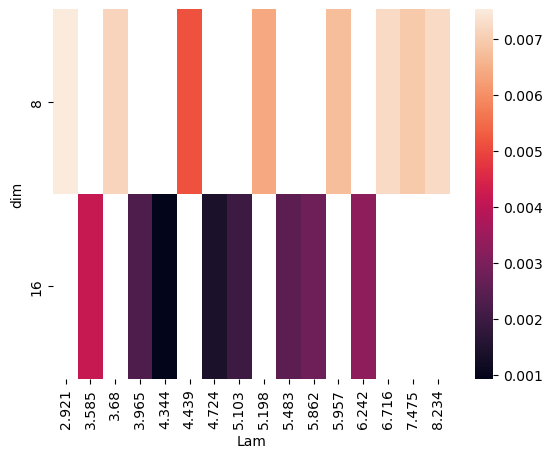

In [6]:
df['Lam'] = df['Model'].apply(lambda x: float(x.split("_")[-1][3:]))
# df["reduced_lam"] = np.linspace(-2.5, 7.5, 8)
df['ESS'] = 100 / df["num_grads_to_low_error"] 
                                            
df['dim'] = df['Model'].apply(lambda x: int(x.split("_")[1][1:]))
# plot
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# sns.set_theme(style="whitegrid")
# matplotlib.rcParams.update({'font.size': 22})
# plt.figure(figsize=(16, 8))
# sns.lineplot(data=df, x='Lam', y='num_grads_to_low_error', hue='Sampler', markers=True, dashes=False)
# sns.lineplot(data=df, x='Lam', y='ESS', hue='Sampler', markers=True, dashes=False)

# sns.heatmap(df.pivot("dim", "Lam", "ESS"), cmap="viridis", annot=True, fmt=".1f", cbar_kws={'label': 'ESS'}, xticklabels=2, yticklabels=2)



new_df = df[df['Sampler']=='nuts'].pivot(index="dim", columns="Lam", values="ESS")
new_df
sns.heatmap(new_df)
# sns.heatmap(data=new_df, x='Lam', y='dim', hue='ESS', cmap="viridis", annot=True, fmt=".1f", cbar_kws={'label': 'ESS'}, xticklabels=2, yticklabels=2)